In [1]:
import pandas as pd
import numpy as np

# Hela ML libraries 
import sys
sys.path.append('../../')
import hela.hmm as hmm
import hela.generation.hmm as hmm_gen

import matplotlib.pyplot as plt
%matplotlib inline

# Utility Libraries
from datetime import datetime
from dask.distributed import Client
from scipy.special import logsumexp
from scipy import stats
import itertools
LOG_ZERO = -1e8

COLOR_MAP = {"light_orange":"#E69F00",
             "light_blue":"#56B4E9",
             "teal":"#009E73",
             "yellow":"#F0E442",
             "dark_blue":"#0072B2",
             "dark_orange":"#D55E00",
             "pink":"#CC79A7",
             "green":"#7fc97f",
             "black":"#000000",
            "silver":"#C0C0C0" }

orange_colors = ["#D55E00","#F0E442","#f8ff81"]
blue_colors = ["#a6cee3","#1f78b4","#f8ff81"]

# Generate Synthetic Data

In this section we will create an instance of `FactoredHMMGenerativeModel`.  The generative model can be instantiated with flexible parameters, and any parameters not defined will be seeded randomly. 

We'll start by creating an instance of the generative model.

In [2]:
generative_model = hmm_gen.FactoredHMMGenerativeModel(
                                     n_hidden_states =[2,2],
                                     n_gaussian_features=2,
                                     n_categorical_features=1)

Now that we have the generative model, we can use this object to generate hidden states in a probabilistic way so that they have the underlying structure of the generative model.

In [3]:
hidden_states = generative_model.generate_hidden_state_sequence(n_observations = 1000)
hidden_states

,0,1
2020-08-01,1,1
2020-08-02,1,1
2020-08-03,1,1
2020-08-04,1,1
2020-08-05,1,1
...,...,...
2023-04-23,0,0
2023-04-24,0,0
2023-04-25,0,0
2023-04-26,0,0


In [4]:
flattened_hidden_states = generative_model.flatten_hidden_state_sequence(hidden_states)
flattened_hidden_states

2020-08-01    3
2020-08-02    3
2020-08-03    3
2020-08-04    3
2020-08-05    3
             ..
2023-04-23    0
2023-04-24    0
2023-04-25    0
2023-04-26    0
2023-04-27    0
Freq: D, Length: 1000, dtype: int64

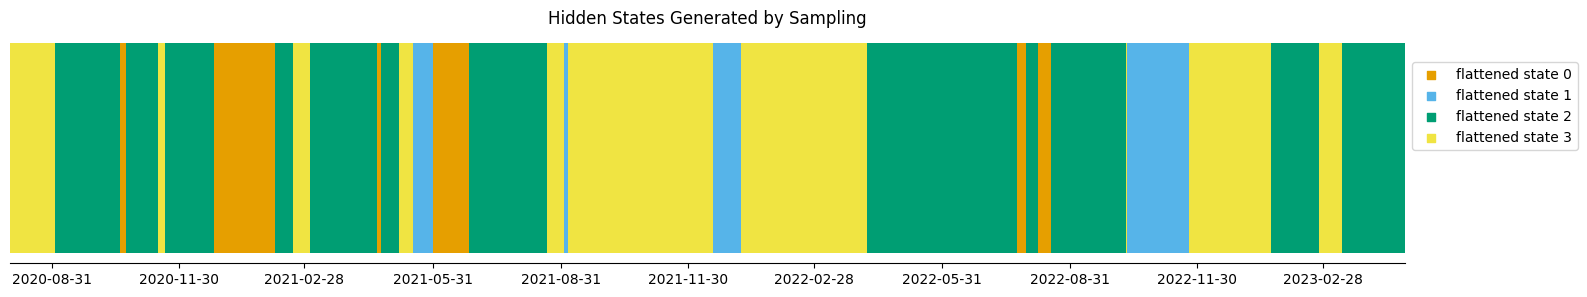

In [5]:
def state_plot(hidden_states, title):    
    splits = [0]
    for i in range(len(hidden_states)-1):
        if hidden_states.iloc[i] != hidden_states.iloc[i+1]:
            splits.append(i)

    fig, ax = plt.subplots(figsize = (18,3))

    left = splits[0]
    colors = list(COLOR_MAP.keys())

    for i in range(len(splits)):
        state = hidden_states.iloc[splits[i]]
        ax.barh(1,splits[i], left = left, color = COLOR_MAP[colors[state]])
        left = splits[i]

    ax.set_yticks([])
    ax.set_xlim(0,len(hidden_states))

    month_index = pd.date_range("2020-08-01",hidden_states.index[-1], freq = "3M")
    x_ticks = [list(hidden_states.index).index(m) for m in month_index]
    labels = [str(m).split(" ")[0] for m in month_index]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(labels)

    for i in range(len(hidden_states.unique())):
        ax.scatter([],[], marker = "s", color = COLOR_MAP[colors[i]], label = "flattened state {}".format(i))

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.legend(bbox_to_anchor = (1,.9), loc = "upper left")
    plt.title(title)
    plt.show()
    
state_plot(flattened_hidden_states, title = "Hidden States Generated by Sampling")

We've set up a series of hidden states, and now we can use this to generate synthetic data that is distributed according to `hidden_states` and the generative model parameters.  We'll also look at some visualizations of the generated data.

In [6]:
data = generative_model.generate_observations(hidden_states)
data.head()

,categorical_feature_0,gaussian_feature_0,gaussian_feature_1
2020-08-01,0,2.762516,1.485715
2020-08-02,1,2.396759,2.977019
2020-08-03,0,3.310945,4.113038
2020-08-04,0,1.848181,5.155589
2020-08-05,0,0.863650,3.427134


In [7]:
training_data = generative_model.generate_observations(hidden_states)
training_data.head()

,categorical_feature_0,gaussian_feature_0,gaussian_feature_1
2020-08-01,0,1.129935,3.417934
2020-08-02,0,0.366058,2.769276
2020-08-03,1,2.053149,3.927373
2020-08-04,0,0.444630,2.278773
2020-08-05,0,0.835343,2.497457


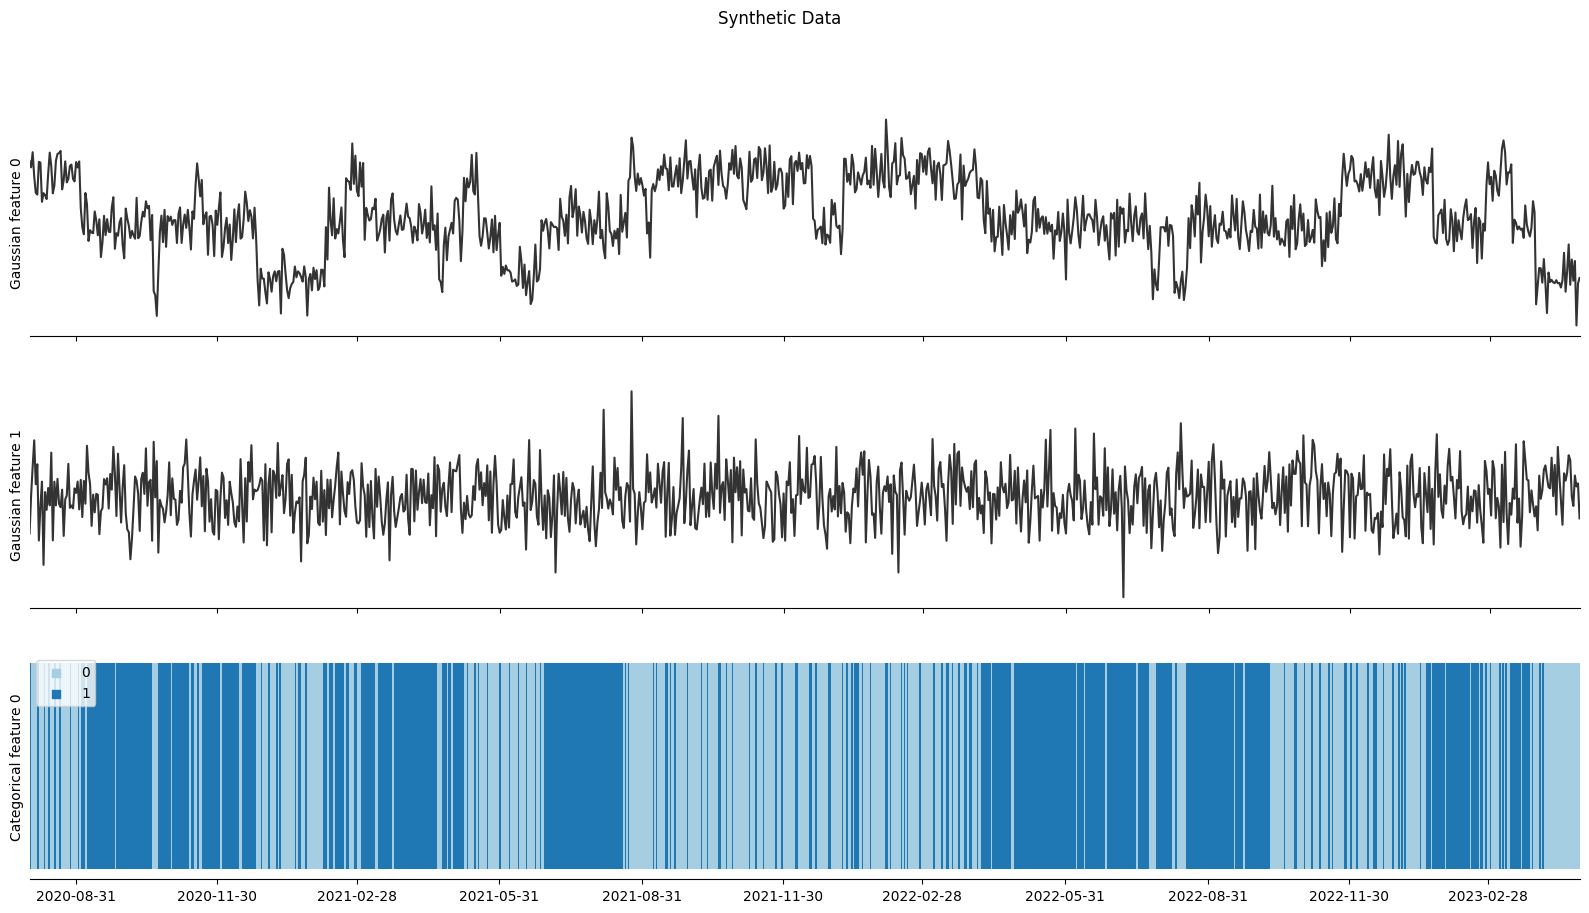

In [8]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (20,10), sharex = False)

# Get tick values and labels.
cat = data["categorical_feature_0"]
month_index = pd.date_range("2020-08-01",cat.index[-1], freq = "3M")
x_ticks = [list(cat.index).index(m) for m in month_index]
labels = [str(m).split(" ")[0] for m in month_index]

# Make Gaussian plot.
gauss = ["gaussian_feature_0","gaussian_feature_1"]
for i in range(len(gauss)):
    ax[i].plot(data[gauss[i]], color = "black", alpha = 0.8)
    ax[i].set_xlim(data.index[0], data.index[-1])


    ax[i].set_xticks(data.index[x_ticks])
    ax[i].set_xticklabels([])
    ax[i].set_yticks([])
    ax[i].set_yticklabels([])

    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_ylabel("Gaussian feature {}".format(i))

# Make Categorical plot.
splits = [0]
for i in range(len(cat)-1):
    if cat.iloc[i] != cat.iloc[i+1]:
        splits.append(i)

left = splits[0]
for i in range(len(splits)):
    state = list(cat.unique()).index(cat.iloc[splits[i]])
    ax[2].barh(1,splits[i], left = left, color = blue_colors[state])
    left = splits[i]

ax[2].set_yticks([])
ax[2].set_xlim(0,cat.shape[0])
ax[2].set_xticks([])
ax[2].set_ylabel("Categorical feature 0")

ax[2].set_xticks(x_ticks)
ax[2].set_xticklabels(labels)

ax[2].spines['top'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].spines['right'].set_visible(False)
    
for i in range(len(cat.unique())):
    ax[2].scatter([],[], marker = "s", color = blue_colors[i], label = "{}".format(cat.unique()[i]))
        
ax[2].legend()

fig.suptitle('Synthetic Data') 
plt.show()

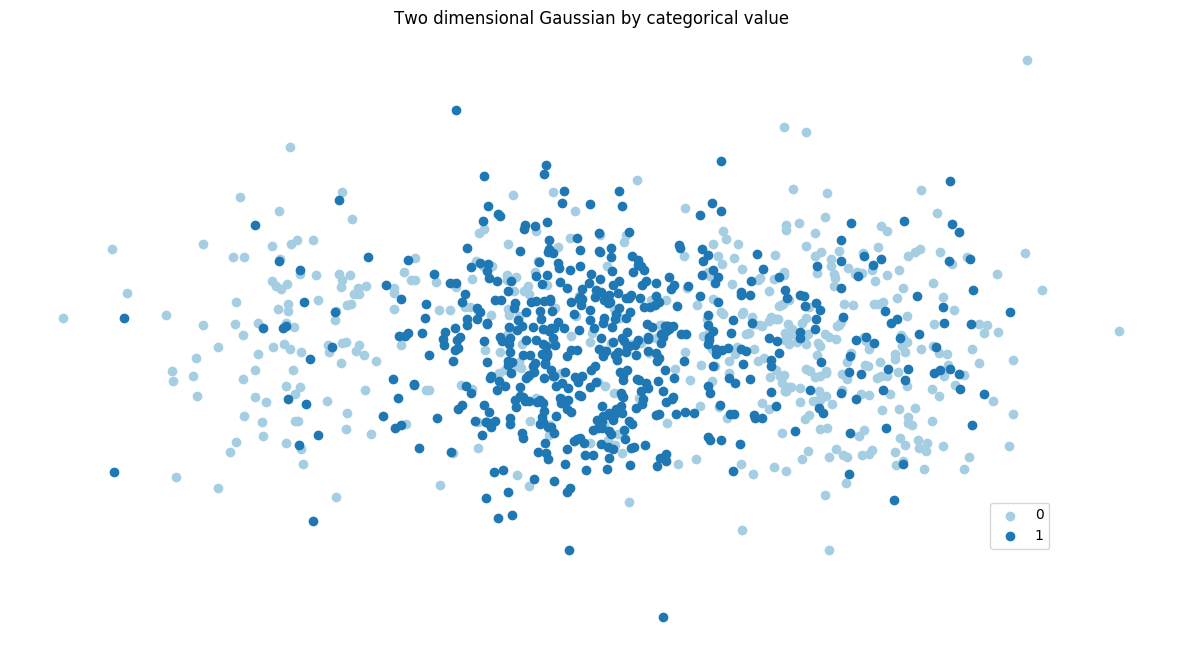

In [9]:
def colored_scatter(data,labels, label_prefix, title):
    fig, ax = plt.subplots(figsize = (15,8))
    markers = {0:"s",1:"^",2:"o"}

    for i in range(len(labels.unique())):
        c = blue_colors[i]
        m = markers[i]
        df = data[labels == labels.unique()[i]]
        ax.scatter(df["gaussian_feature_0"],df["gaussian_feature_1"], c=c, label = "{}".format(labels.unique()[i]))

    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
        
    plt.title(title)
    plt.legend(bbox_to_anchor = (.9,.15), loc = "lower right")
    plt.show()
    
colored_scatter(data = data, 
                labels = data["categorical_feature_0"], 
                label_prefix = "categorical feature", 
                title = "Two dimensional Gaussian by categorical value")

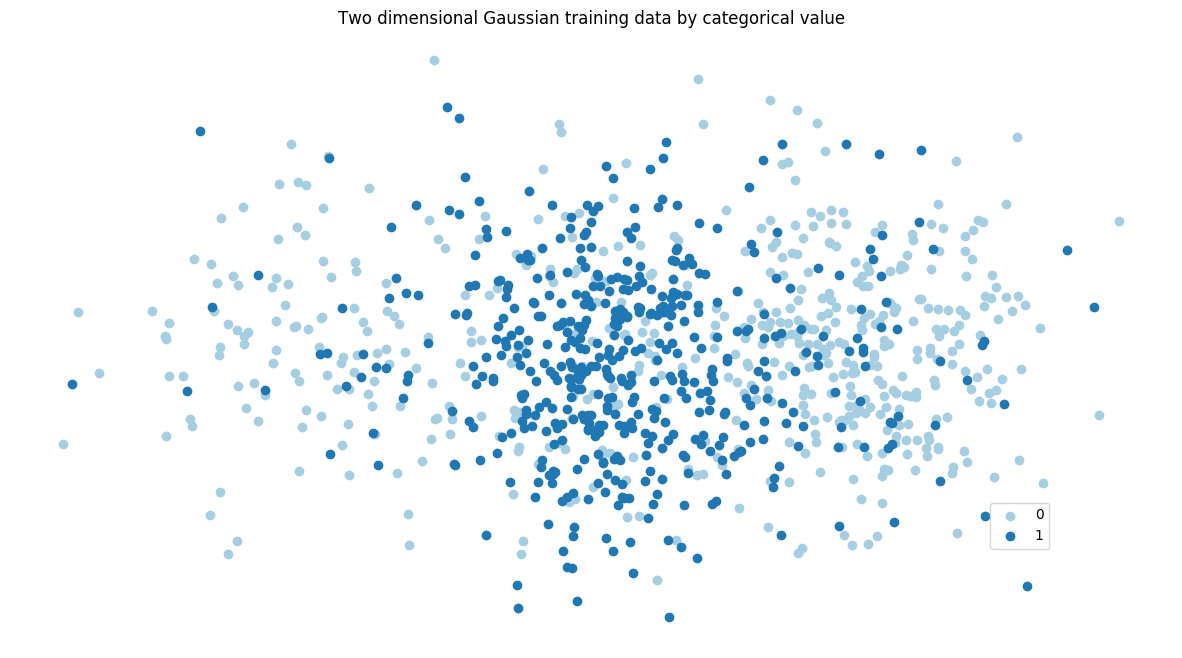

In [10]:
colored_scatter(data = training_data, 
                labels = training_data["categorical_feature_0"], 
                label_prefix = "categorical feature", 
                title = "Two dimensional Gaussian training data by categorical value")

# FHMM Training

Begin my obtaining a training spec and model config from the data generative model.  The `fhmm_training_spec` below will be a close match to the original data, but not an exact replica of the genrative model

In [11]:
fhmm_training_spec = hmm_gen.data_to_fhmm_training_spec(hidden_states=hidden_states, 
                                       n_hidden_states=generative_model.n_hidden_states, 
                                       data=data, 
                                       categorical_features = list(generative_model.categorical_values.columns),
                                       gaussian_features=list(generative_model.gaussian_values.columns))

# Get fHMM Configuration instance from fhmm training spec.
fhmm_config = hmm.FactoredHMMConfiguration.from_spec(fhmm_training_spec)

# Get fHMM Model instance from configuration.
fhmm_model = fhmm_config.to_model()

In [12]:
# Get true model log likelihood.

true_fhmm_spec = generative_model.generative_model_to_fhmm_training_spec()
true_fhmm_config = hmm.FactoredHMMConfiguration.from_spec(true_fhmm_spec)
true_fhmm_model = true_fhmm_config.to_model()
true_hmm_training_spec = hmm._factored_hmm_to_discrete_hmm(true_fhmm_model)
true_hmm_config = hmm.DiscreteHMMConfiguration.from_spec(true_hmm_training_spec)
true_hmm_model = true_hmm_config.to_model()

hmm_inf = true_hmm_model.load_inference_interface()
log_prob = hmm_inf.predict_hidden_state_log_probability(data)
ll = -1 * logsumexp(hmm_inf._compute_forward_probabilities(log_prob)[-1])

print("Complete data negative log likelihood: {}".format(ll))

Complete data negative log likelihood: 3407.8022845271


### Flattened HMM 

We will begin by defining a so-called "flattened HMM" from the fHMM by replacing the $N$ hidden states for each of $M$ Markov systems with $N^M$ enumerated hidden states.

We will define a training spec seeded with values from the generative model (this isn't an exact copy of the hmm underlying the gerneative model, but it's meant to be "close enough").

In [13]:
# Flatten fhmm to get discrete HMM training spec
hmm_training_spec = hmm._factored_hmm_to_discrete_hmm(fhmm_model)

# Get HMM Configuration instance from fhmm training spec.
hmm_config = hmm.DiscreteHMMConfiguration.from_spec(hmm_training_spec)

# Get HMM Model instance from configuration.
hmm_model = hmm_config.to_model()

In [14]:
# Flatten fhmm to get discrete HMM training spec
hmm_training_spec = hmm._factored_hmm_to_discrete_hmm(fhmm_model)

# Get HMM Configuration instance from fhmm training spec.
hmm_config = hmm.DiscreteHMMConfiguration.from_spec(hmm_training_spec)

In [15]:
em_train_ll = []

# Get HMM Model instance from configuration.
untrained_model = hmm_config.to_model(set_random_state = 0)

# Load learning algorithm.
alg = untrained_model.load_learning_interface()

# Train model.
n_em_iterations = 10
em_model = alg.run(untrained_model, training_data, n_em_iterations)

em_train_likelihood = []
for m in alg.model_results:

    hmm_inf = m.load_inference_interface()
    log_prob = hmm_inf.predict_hidden_state_log_probability(training_data)
    em_train_likelihood.append(
            -1 * logsumexp(hmm_inf._compute_forward_probabilities(log_prob)[-1]))

em_train_ll.append(em_train_likelihood)

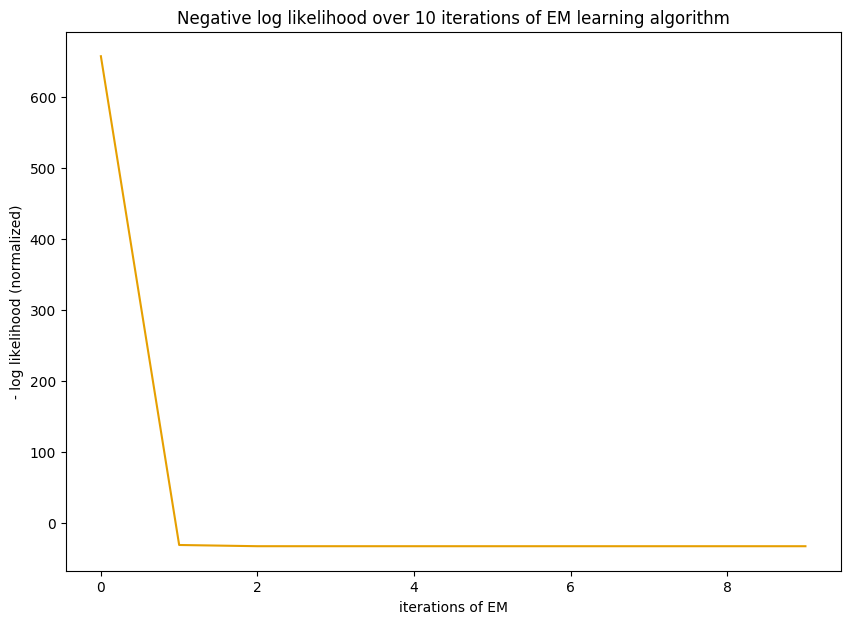

In [16]:
plt.figure(figsize = (10,7))

i = 0
for train_ll in em_train_ll:
    color = COLOR_MAP[list(COLOR_MAP.keys())[i]]
    plt.plot(np.array(train_ll)-ll, color = color)
    i = i +1

plt.title("Negative log likelihood over {} iterations of EM learning algorithm".format(n_em_iterations))

plt.ylabel("- log likelihood (normalized)")
plt.xlabel("iterations of EM")
plt.show()

### Factored HMM

In [17]:
fhmm_training_spec = hmm_gen.data_to_fhmm_training_spec(hidden_states, 
                                   generative_model.n_hidden_states, 
                                   training_data,
                                   categorical_features = list(generative_model.categorical_values.columns), 
                                   gaussian_features = list(generative_model.gaussian_values.columns)
                                                       )

fhmm_config = hmm.FactoredHMMConfiguration.from_spec(fhmm_training_spec)
untrained_fhmm_model = fhmm_config.to_model()

#### Train with VI

In [18]:
vi_alg = untrained_fhmm_model.load_learning_interface()

n_vi_iterations = 100

vi_model = vi_alg.run(
    data=training_data,
    method='structured_vi',
    training_iterations=n_vi_iterations)

In [19]:
vi_train_ll = []

vi_train_likelihood = []
for m in vi_alg.model_results:
    spec = hmm._factored_hmm_to_discrete_hmm(m)
    hmm_config = hmm.DiscreteHMMConfiguration.from_spec(spec)
    hmm_model = hmm_config.to_model()
    hmm_inf = hmm_model.load_inference_interface()
    log_prob = hmm_inf.predict_hidden_state_log_probability(training_data)
    vi_train_likelihood.append(
            -1 * logsumexp(hmm_inf._compute_forward_probabilities(log_prob)[-1]))
    
vi_train_ll.append(vi_train_likelihood)

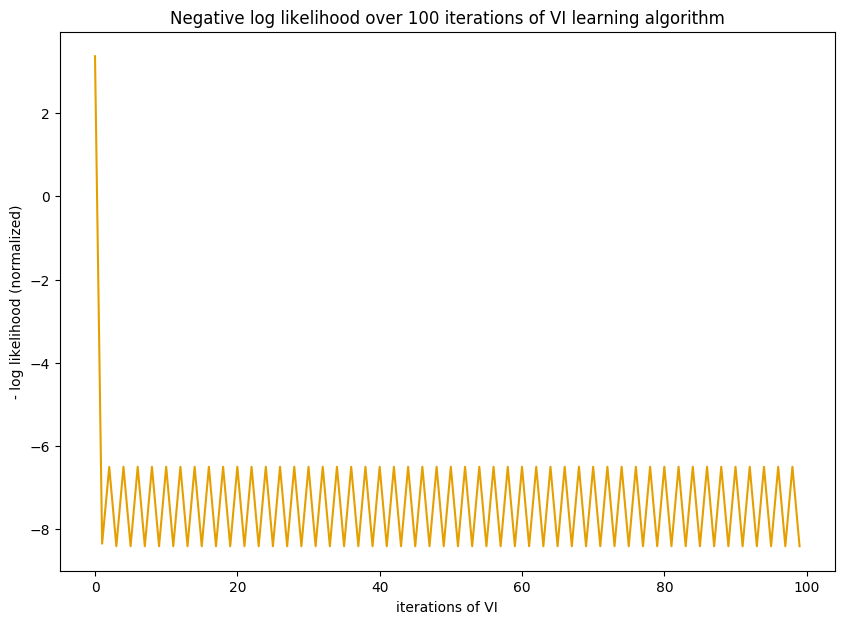

In [20]:
plt.figure(figsize = (10,7))

i = 0
for train_ll in vi_train_ll:
    color = COLOR_MAP[list(COLOR_MAP.keys())[i]]
    plt.plot(np.array(train_ll)-ll, color = color)
    i = i +1

plt.title("Negative log likelihood over {} iterations of VI learning algorithm".format(n_vi_iterations))

plt.ylabel("- log likelihood (normalized)")
plt.xlabel("iterations of VI")
plt.show()

#### Train with Gibbs

In [21]:
gibbs_alg = untrained_fhmm_model.load_learning_interface()

n_gibbs_iterations = 5

gibbs_model = gibbs_alg.run(
    data=training_data,
    method='gibbs',
    gibbs_iterations = 5,
    training_iterations=n_gibbs_iterations)

In [22]:
gibbs_train_ll = []

gibbs_train_likelihood = []
for m in gibbs_alg.model_results:
    spec = hmm._factored_hmm_to_discrete_hmm(m)
    hmm_config = hmm.DiscreteHMMConfiguration.from_spec(spec)
    hmm_model = hmm_config.to_model()
    hmm_inf = hmm_model.load_inference_interface()
    log_prob = hmm_inf.predict_hidden_state_log_probability(training_data)
    gibbs_train_likelihood.append(
            -1 * logsumexp(hmm_inf._compute_forward_probabilities(log_prob)[-1]))
    
gibbs_train_ll.append(gibbs_train_likelihood)

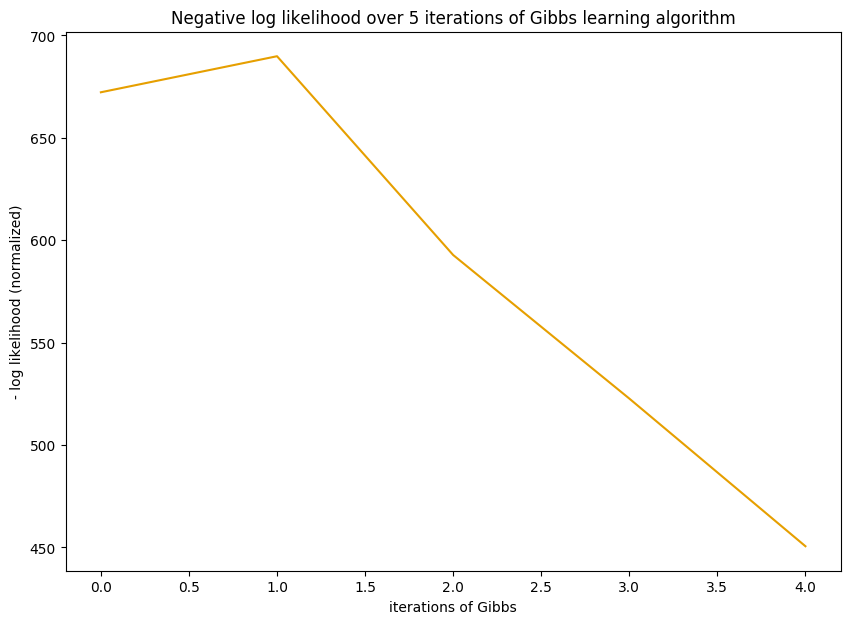

In [23]:
plt.figure(figsize = (10,7))

i = 0
for train_ll in gibbs_train_ll:
    color = COLOR_MAP[list(COLOR_MAP.keys())[i]]
    plt.plot(np.array(train_ll)-ll, color = color)
    i = i +1

plt.title("Negative log likelihood over {} iterations of Gibbs learning algorithm".format(n_gibbs_iterations))

plt.ylabel("- log likelihood (normalized)")
plt.xlabel("iterations of Gibbs")
plt.show()

# FHMM Inference

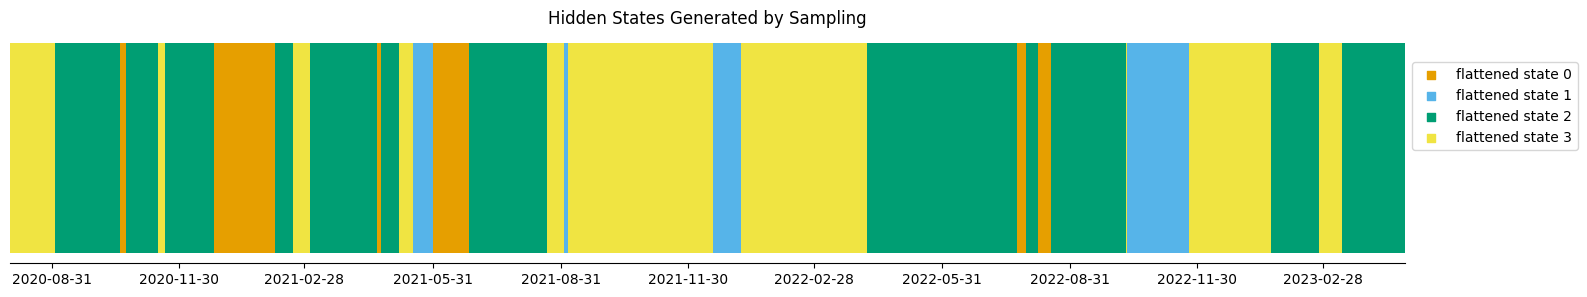

In [24]:
state_plot(flattened_hidden_states, title = "Hidden States Generated by Sampling")

### Inference with Viterbi and VI

In [29]:
inf = vi_model.load_inference_interface(use_jax = False)
vi_hidden_state_vector_df = inf.predict_hidden_states_log_viterbi(data)

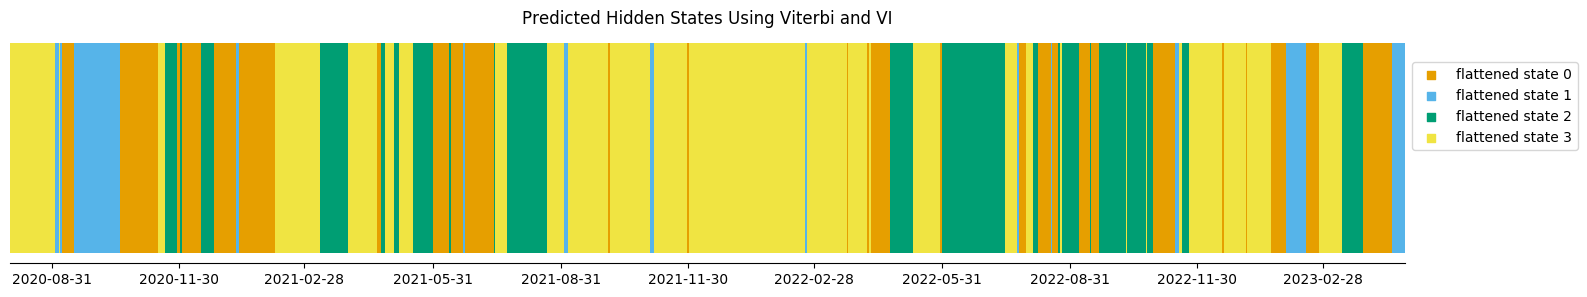

In [30]:
vi_flattened_hidden_states = generative_model.flatten_hidden_state_sequence(vi_hidden_state_vector_df)

state_plot(vi_flattened_hidden_states, title = "Predicted Hidden States Using Viterbi and VI")

In [31]:
p_any = np.sum(np.any(np.array(vi_hidden_state_vector_df) == np.array(hidden_states), axis = 1)) / data.shape[0]
p_all = np.sum(np.all(np.array(vi_hidden_state_vector_df) == np.array(hidden_states), axis = 1)) / data.shape[0]

print("{}% of the time VI returned the correct hidden state for at least one system.".format(int(p_any *100)))
print("")
print("{}% of the time VI returned the correct hidden state for every system.".format(int(p_all *100)))

90% of the time VI returned the correct hidden state for at least one system.

64% of the time VI returned the correct hidden state for every system.


### Inferfence with Gibbs Sampling

In [33]:
inf = gibbs_model.load_inference_interface(use_jax = False)

Gamma, Xi, gibbs_hidden_state_vector_df = inf.gibbs_sampling(data,
                                                       iterations = 50,
                                                       burn_down_period=0)

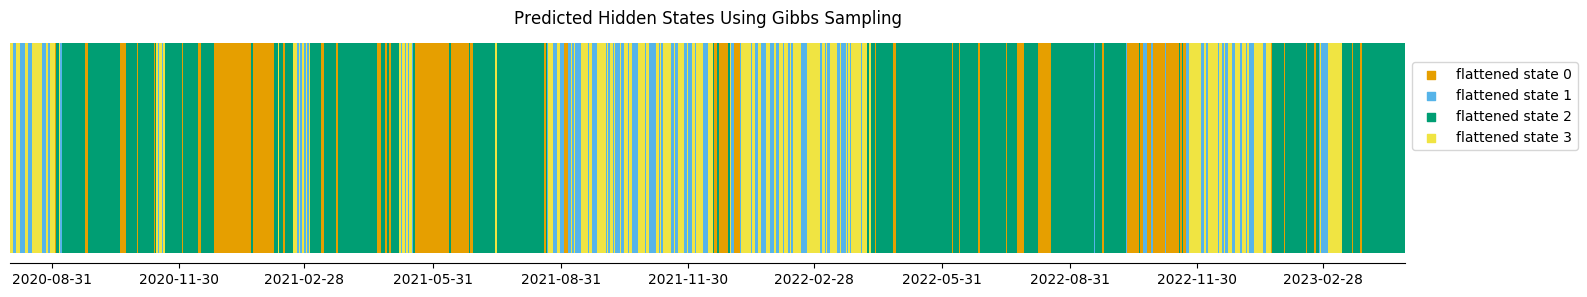

In [34]:
gibbs_flattened_hidden_states = generative_model.flatten_hidden_state_sequence(gibbs_hidden_state_vector_df)
state_plot(gibbs_flattened_hidden_states, title = "Predicted Hidden States Using Gibbs Sampling")

In [35]:
p_any = np.sum(np.any(np.array(gibbs_hidden_state_vector_df) == np.array(hidden_states), axis = 1)) / data.shape[0]
p_all = np.sum(np.all(np.array(gibbs_hidden_state_vector_df) == np.array(hidden_states), axis = 1)) / data.shape[0]

print("{}% of the time Gibbs returned the correct hidden state for at least one system.".format(int(p_any *100)))
print("")
print("{}% of the time Gibbs returned the correct hidden state for every system.".format(int(p_all *100)))

99% of the time Gibbs returned the correct hidden state for at least one system.

75% of the time Gibbs returned the correct hidden state for every system.
